## Download latest CSSE data

In [3]:
! curl https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv > csse_covid_19_time_series/time_series_19-covid-Confirmed.csv
! curl https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv > csse_covid_19_time_series/time_series_19-covid-Deaths.csv
! curl https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv > csse_covid_19_time_series/time_series_19-covid-Recovered.csv   

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 83339  100 83339    0     0   395k      0 --:--:-- --:--:-- --:--:--  395k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 76698  100 76698    0     0   396k      0 --:--:-- --:--:-- --:--:--  396k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 79306  100 79306    0     0   416k      0 --:--:-- --:--:-- --:--:--  416k


## Build dataframe containing all timeseries data

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

fields = ['Confirmed', 'Deaths', 'Recovered']
df_list = []
for field in fields:
    df_temp = pd.read_csv(
        'csse_covid_19_time_series/time_series_19-covid-%s.csv' % field)
    df = df_temp.melt(
        id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'],
        var_name='date',
        value_name=field.lower())
    df.date = pd.to_datetime(df.date)
    df_list.append(df)

df = pd.merge(df_list[0],
              df_list[1],
              on=['Province/State', 'Country/Region', 'Lat', 'Long', 'date'])
df = pd.merge(df,
              df_list[2],
              on=['Province/State', 'Country/Region', 'Lat', 'Long', 'date'])

df = df.set_index('date')

df

Province/State Country/Region      Lat      Long  confirmed  \
date                                                                     
2020-01-22            NaN       Thailand  15.0000  101.0000          2   
2020-01-22            NaN          Japan  36.0000  138.0000          2   
2020-01-22            NaN      Singapore   1.2833  103.8333          0   
2020-01-22            NaN          Nepal  28.1667   84.2500          0   
2020-01-22            NaN       Malaysia   2.5000  112.5000          0   
...                   ...            ...      ...       ...        ...   
2020-03-22            NaN       Dominica  15.4150  -61.3710          1   
2020-03-22            NaN        Grenada  12.1165  -61.6790          1   
2020-03-22            NaN     Mozambique -18.6657   35.5296          1   
2020-03-22            NaN          Syria  34.8021   38.9968          1   
2020-03-22            NaN    Timor-Leste  -8.8742  125.7275          1   

            deaths  recovered  
date                           
2020-01-22       0          0  
2020-01-22       0          0  
2020-01-22       0          0  
2020-01-22       0          0  
2020-01-22       0          0  
...            ...        ...  
2020-03-22       0          0  
2020-03-22       0          0  
2020-03-22       0          0  
2020-03-22       0          0  
2020-03-22       0          0  

[29707 rows x 7 columns]

## Aggregate data per country

In [5]:
df_country = df.groupby(['Country/Region', 'date']).agg({
    'Lat': 'first',
    'Long': 'first',
    'confirmed': 'sum',
    'deaths': 'sum',
    'recovered': 'sum'
})

df_country['active'] = df_country['confirmed'] - df_country[
    'deaths'] - df_country['recovered']

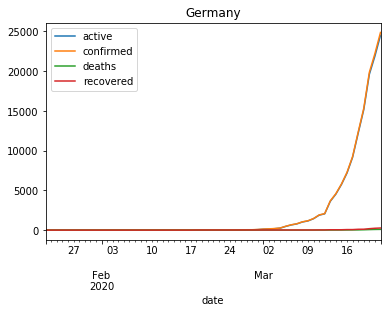

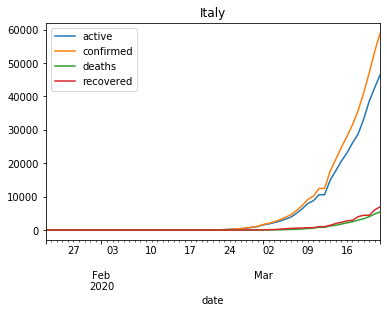

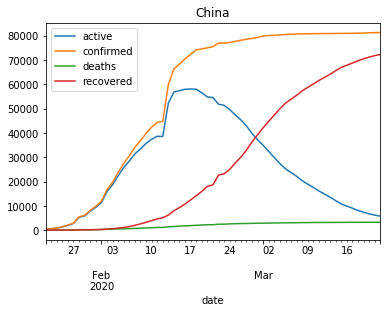

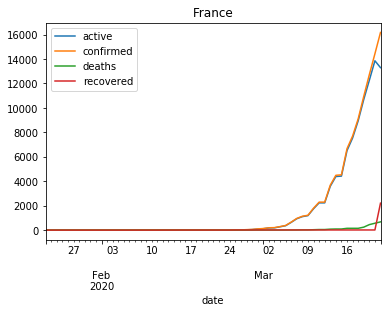

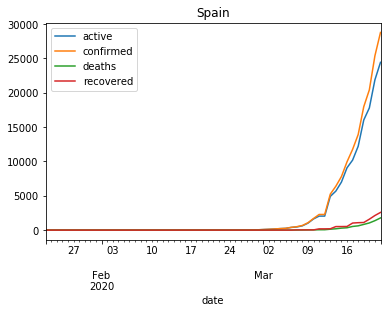

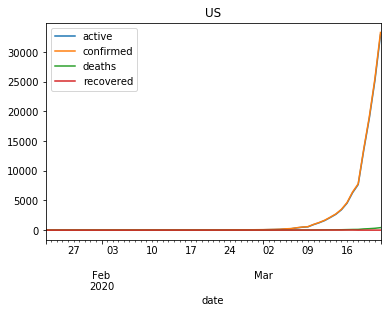

In [6]:
countries = ['Germany', 'Italy', 'China', 'France', 'Spain', 'US']

for country in countries:
    df_country.loc[country][['active', 'confirmed', 'deaths',
                             'recovered']].plot()
    #plt.yscale('log')
    plt.title(country)
    plt.show()

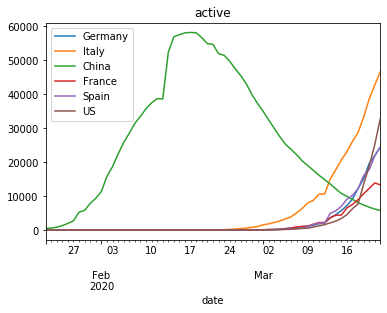

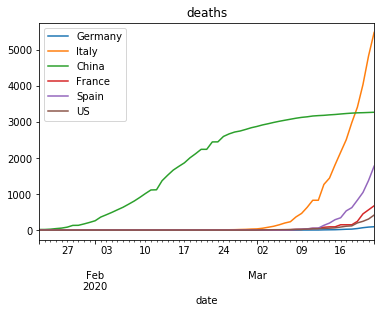

In [7]:
countries = ['Germany', 'Italy', 'China', 'France', 'Spain', 'US']
columns = ['active', 'deaths']

for column in columns:
    for country in countries:
        df_country.loc[country][column].plot()
        #plt.yscale('log')
    plt.legend(countries)
    plt.title(column)
    plt.show()

## Fit model to "deaths" curve

/Users/mcs/Repositories/homebound-app/data-analysis/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


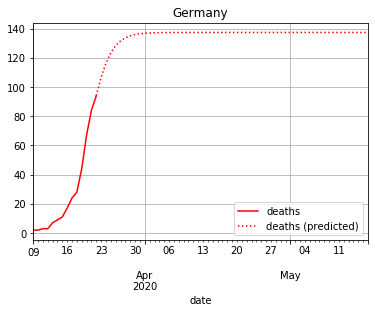

date      deaths        type
0   2020-03-09    2.000000  historical
1   2020-03-10    2.000000  historical
2   2020-03-11    3.000000  historical
3   2020-03-12    3.000000  historical
4   2020-03-13    7.000000  historical
..         ...         ...         ...
65  2020-05-13  137.370466  prediction
66  2020-05-14  137.370466  prediction
67  2020-05-15  137.370466  prediction
68  2020-05-16  137.370466  prediction
69  2020-05-17  137.370466  prediction

[70 rows x 3 columns]

In [18]:
from scipy.optimize import curve_fit
import numpy as np
import math


def f2(f0):
    def f(x, k, G, f0=f0):
        res = []
        for x_el in x:
            res.append(G * 1 / (1 + math.exp(-k * G * x_el) * (G / f0 - 1)))
        return res

    return f


country = 'Germany'

df_deaths = df_country.loc[country][df_country.loc[country]['deaths'] > 0][[
    'deaths'
]]
y = df_deaths['deaths'].values.tolist()
x = np.arange(len(y))
x = x - max(x)

popt, _ = curve_fit(f2(y[-1]),
                    xdata=x,
                    ydata=y,
                    p0=(0.00001, y[-1]),
                    method='dogbox')

x2 = np.arange(8 * 7 + 1)  # next ... days
y2 = f2(y[-1])(x2, popt[0], popt[1])

df_deaths['type'] = 'historical'
df_deaths_pred = pd.DataFrame(data=y2,
                              index=pd.date_range(start=max(df_deaths.index),
                                                  periods=len(x2),
                                                  freq='D'),
                              columns=['deaths'])

df_deaths_pred['type'] = 'prediction'

df_deaths['deaths'].plot(style='r')
df_deaths_pred['deaths'].plot(style='r:')
plt.legend(['deaths', 'deaths (predicted)'])
plt.title(country)
plt.grid(True)
plt.show()

df_temp = pd.concat([df_deaths, df_deaths_pred[1:]])
df_temp = df_temp.reset_index().rename(columns={'index': 'date'})
df_temp.date = df_temp.date.dt.strftime('%Y-%m-%d')
df_temp.to_json('deaths_%s.json' % country)
display(df_temp)

## Fit model to "active" curve

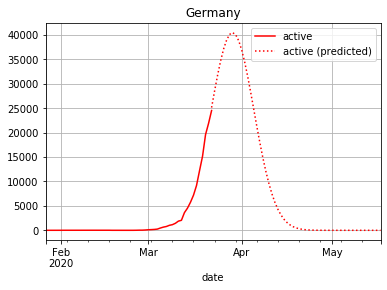

date    active        type
0    2020-01-27  1.000000  historical
1    2020-01-28  4.000000  historical
2    2020-01-29  4.000000  historical
3    2020-01-30  4.000000  historical
4    2020-01-31  5.000000  historical
..          ...       ...         ...
107  2020-05-13  0.000075  prediction
108  2020-05-14  0.000030  prediction
109  2020-05-15  0.000012  prediction
110  2020-05-16  0.000005  prediction
111  2020-05-17  0.000002  prediction

[112 rows x 3 columns]

['2020-01-27', '2020-01-28', '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09', '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13', '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06', '2020

In [21]:
from scipy.optimize import curve_fit
import numpy as np
import math


def g2(f0):
    def g(x, a, b, c):
        #        print(a, b, c)
        res = []
        for x_el in x:
            res.append(a * math.exp(-b * (x_el - c)**2))
        return res

    return g


country = 'Germany'

df_active = df_country.loc[country][df_country.loc[country]['active'] > 0][[
    'active'
]]
y = df_active['active'].values.tolist()
x = np.arange(len(y))
x = x - max(x)

# 30000, 0.01, 5
# (80000, 0.01, -20),
popt, _ = curve_fit(g2(y[-1]),
                    xdata=x,
                    ydata=y,
                    p0=(30000, 0.01, 5),
                    method='dogbox')

x2 = np.arange(7 * 8 + 1)  # next ... days
y2 = g2(y[-1])(x2, *popt)

df_active['type'] = 'historical'
df_active_pred = pd.DataFrame(data=y2,
                              index=pd.date_range(start=max(df_active.index),
                                                  periods=len(x2),
                                                  freq='D'),
                              columns=['active'])

df_active_pred['type'] = 'prediction'

df_active['active'].plot(style='r')
df_active_pred['active'].plot(style='r:')
plt.legend(['active', 'active (predicted)'])
plt.title(country)
plt.grid(True)
plt.show()

df_temp = pd.concat([df_active, df_active_pred[1:]])
df_temp = df_temp.reset_index().rename(columns={'index': 'date'})
df_temp.date = df_temp.date.dt.strftime('%Y-%m-%d')
df_temp.to_json('active_%s.json' % country)
display(df_temp)

x = []
y = []
y1 = []
y2 = []
data = []
for i in range(df_temp.shape[0]):
    x.append(df_temp.date[i])
    y.append(df_temp.active[i])
    if df_temp.type[i] == 'historical':
        y1.append(df_temp.active[i])
        y2.append(None)
        data.append({
            'date': df_temp.date[i],
            'active': round(df_temp.active[i]),
            'active_predicted': 0
        })
    else:
        y1.append(None)
        y2.append(df_temp.active[i])
        data.append({
            'date': df_temp.date[i],
            'active': 0,
            'active_predicted': round(df_temp.active[i])
        })
#print(x)
#print(data)

## Fit model to "confirmed" curve

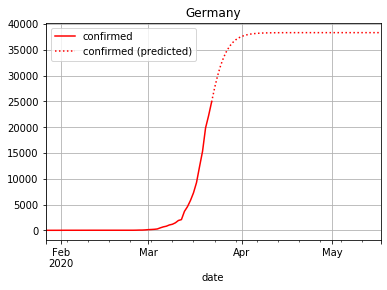

date     confirmed        type
0    2020-01-27      1.000000  historical
1    2020-01-28      4.000000  historical
2    2020-01-29      4.000000  historical
3    2020-01-30      4.000000  historical
4    2020-01-31      5.000000  historical
..          ...           ...         ...
107  2020-05-13  38331.087625  prediction
108  2020-05-14  38331.087803  prediction
109  2020-05-15  38331.087931  prediction
110  2020-05-16  38331.088023  prediction
111  2020-05-17  38331.088088  prediction

[112 rows x 3 columns]

In [20]:
from scipy.optimize import curve_fit
import numpy as np
import math


def f2(f0):
    def f(x, k, G, f0=f0):
        res = []
        for x_el in x:
            res.append(G * 1 / (1 + math.exp(-k * G * x_el) * (G / f0 - 1)))
        return res

    return f


country = 'Germany'

df_confirmed = df_country.loc[country][
    df_country.loc[country]['confirmed'] > 0][['confirmed']]
y = df_confirmed['confirmed'].values.tolist()
x = np.arange(len(y))
x = x - max(x)

# 30000, 0.01, 5
# (80000, 0.01, -20),
popt, _ = curve_fit(f2(y[-1]),
                    xdata=x,
                    ydata=y,
                    p0=(0.00001, y[-1]),
                    method='dogbox')

x2 = np.arange(7 * 8 + 1)  # next ... days
y2 = f2(y[-1])(x2, *popt)

df_confirmed['type'] = 'historical'
df_confirmed_pred = pd.DataFrame(data=y2,
                                 index=pd.date_range(start=max(
                                     df_confirmed.index),
                                                     periods=len(x2),
                                                     freq='D'),
                                 columns=['confirmed'])

df_confirmed_pred['type'] = 'prediction'

df_confirmed['confirmed'].plot(style='r')
df_confirmed_pred['confirmed'].plot(style='r:')
plt.legend(['confirmed', 'confirmed (predicted)'])
plt.title(country)
plt.grid(True)
plt.show()

df_temp = pd.concat([df_confirmed, df_confirmed_pred[1:]])
df_temp = df_temp.reset_index().rename(columns={'index': 'date'})
df_temp.date = df_temp.date.dt.strftime('%Y-%m-%d')
df_temp.to_json('confirmed_%s.json' % country)
display(df_temp)

## Aggregate worldwide data

In [11]:
df_world = df.groupby(['date']).agg({
    'confirmed': 'sum',
    'deaths': 'sum',
    'recovered': 'sum'
})

df_world['active'] = df_world['confirmed'] - df_world['deaths'] - df_world[
    'recovered']

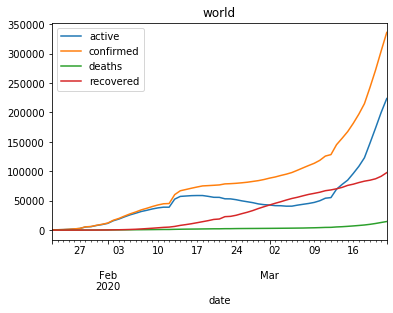

In [14]:
df_world[['active', 'confirmed', 'deaths', 'recovered']].plot()
#plt.yscale('log')
plt.title('world')
plt.show()